In [1]:
import requests
from bs4 import BeautifulSoup 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from time import strftime
from time import sleep
import os
import json
from typing import Dict, List, Optional, Union, cast
import acquire
from prepare import *
import json
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from env import github_username, github_token

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarahwoods/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarahwoods/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Acquire

In [2]:
data = pd.read_json('data.json')

In [3]:
data.head()

,repo,language,readme_contents
0,thedaviddias/Front-End-Checklist,None,"<h1 align=""center"">\n<br>\n <img src=""https:/..."
1,onevcat/Kingfisher,Swift,"<p align=""center"">\n<img src=""https://raw.gith..."
2,FallibleInc/security-guide-for-developers,None,# 实用性 WEB 开发人员安全须知 \n\n### 目标读者 \n\n安全问题主要由以...
3,tailwindlabs/tailwindcss,JavaScript,"<p>\n <a href=""https://tailwindcss.com/"" ta..."
4,codepath/android_guides,None,# CodePath Android Cliffnotes\n\nWelcome to th...


# Prepare

In [4]:
data.isna().sum()

repo                0
language           54
readme_contents     0
dtype: int64

In [5]:
# removed languages that were 'none'
data = data.dropna()

In [6]:
len(data)

506

In [7]:
data.language.value_counts()

JavaScript          141
Python               59
Java                 46
TypeScript           45
Go                   36
C++                  30
C                    20
Shell                13
Swift                13
HTML                 12
Rust                 11
C#                    9
Kotlin                9
Ruby                  9
PHP                   6
Vue                   6
Jupyter Notebook      6
Vim script            6
CSS                   5
Objective-C           3
Lua                   2
Haskell               2
CoffeeScript          2
TeX                   2
Elixir                2
Rascal                1
Standard ML           1
Makefile              1
Clojure               1
Crystal               1
Emacs Lisp            1
AsciiDoc              1
Dart                  1
OCaml                 1
Batchfile             1
Dockerfile            1
Name: language, dtype: int64

In [8]:
# brought the dataset down to those languages that were more than or equal to 30
data = data[data['language'].map(data['language'].value_counts()) >= 30]

In [9]:
len(data)

357

<AxesSubplot:>

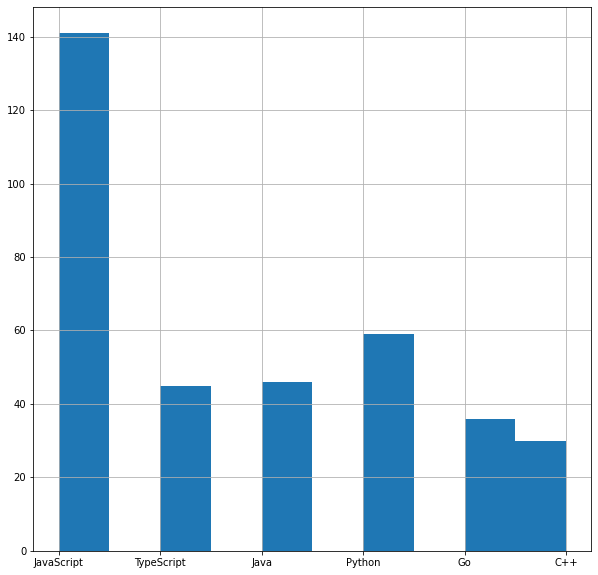

In [10]:
plt.figure(figsize=(10, 10))
data.language.hist(align = 'mid')

In [11]:
data.isna().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [12]:
data = prep_readme_data(df= data, column = 'readme_contents', extra_words=['https','p','com','http','href'], exclude_words=[])

In [13]:
data = data.drop(columns = ['readme_contents'])

In [14]:
data.head()

,repo,language,clean,stemmed,lemmatized
3,tailwindlabs/tailwindcss,JavaScript,hrefhttpstailwindcsscom target_blank img altta...,hrefhttpstailwindcsscom target_blank img altta...,hrefhttpstailwindcsscom target_blank img altta...
5,github/fetch,JavaScript,windowfetch polyfill fetch function promisebas...,windowfetch polyfil fetch function promisebas ...,windowfetch polyfill fetch function promisebas...
7,ianstormtaylor/slate,TypeScript,aligncenter hrefimg srcdocsimagesbannerpng ali...,aligncent hrefimg srcdocsimagesbannerpng align...,aligncenter hrefimg srcdocsimagesbannerpng ali...
8,Kong/insomnia,JavaScript,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...
9,CymChad/BaseRecyclerViewAdapterHelper,Java,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...,httpsuserimagesgithubusercontentcom76982093319...


# Explore 

In [15]:
data.language.value_counts(normalize = True)

JavaScript    0.394958
Python        0.165266
Java          0.128852
TypeScript    0.126050
Go            0.100840
C++           0.084034
Name: language, dtype: float64

In [16]:
data.language.value_counts()

JavaScript    141
Python         59
Java           46
TypeScript     45
Go             36
C++            30
Name: language, dtype: int64

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 3 to 559
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   repo        357 non-null    object
 1   language    357 non-null    object
 2   clean       357 non-null    object
 3   stemmed     357 non-null    object
 4   lemmatized  357 non-null    object
dtypes: object(5)
memory usage: 16.7+ KB


In [18]:
data.describe()

,repo,language,clean,stemmed,lemmatized
count,357,357,357,357,357
unique,357,6,356,356,356
top,alibaba/Sentinel,JavaScript,,,
freq,1,141,2,2,2


In [22]:
def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [25]:
# combine all messages in single string by label

JavaScript_words = clean(' '.join(data[data.language == 'JavaScript'].stemmed))
Python_words = clean(' '.join(data[data.language == 'Python'].stemmed))
TS_words = clean(' '.join(data[data.language == 'TypeScript'].stemmed))
Java_words = clean(' '.join(data[data.language == 'Java'].stemmed))
Go_words = clean(' '.join(data[data.language == 'Go'].stemmed))
C_words = clean(' '.join(data[data.language == 'C++'].stemmed))
all_words = clean(' '.join(data.stemmed))

In [26]:
# making a df for each language 
js_df = data[data.language == 'JavaScript']
python_df = data[data.language == 'Python']
java_df = data[data.language == 'Java']
ts_df = data[data.language == 'TypeScript']
go_df = data[data.language == 'Go']
c_df = data[data.language == 'C++']

In [27]:
js_df.head()

,repo,language,clean,stemmed,lemmatized
3,tailwindlabs/tailwindcss,JavaScript,hrefhttpstailwindcsscom target_blank img altta...,hrefhttpstailwindcsscom target_blank img altta...,hrefhttpstailwindcsscom target_blank img altta...
5,github/fetch,JavaScript,windowfetch polyfill fetch function promisebas...,windowfetch polyfil fetch function promisebas ...,windowfetch polyfill fetch function promisebas...
8,Kong/insomnia,JavaScript,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...,insomnia rest client slack channelhttpschatins...
12,SheetJS/sheetjs,JavaScript,sheetjshttpssheetjscom parser writer various s...,sheetjshttpssheetjscom parser writer variou sp...,sheetjshttpssheetjscom parser writer various s...
15,angular/material,JavaScript,material design angularjs apps npm versionhttp...,materi design angularj app npm versionhttpsbad...,material design angularjs apps npm versionhttp...


In [29]:
TS_words

'aligncent hrefimg srcdocsimagesbannerpng aligncent emcompletelyem customiz framework br build rich text editor br aligncent hrefwhystrongwhystronga hrefprinciplesstrongprinciplesstronga hrefhttpslatejsorgstrongdemostronga hrefexamplesstrongexamplesstronga hrefhttpdocsslatejsorgstrongdocumentationstronga hrefcontributingstrongcontributingstronga br aligncent hrefhttpslatejsorgimg srcdocsimagespreviewpnga aligncent hrefhttpsunpkgcomslatedistslateminj img srchttpimgbadgesizeiohttpsunpkgcomslatedistslateminjscompressiongzipamplabels hrefhttpsslateslackherokuappcom img srchttpsslateslackherokuappcombadgesvg hrefpackagesslatepackagejson img srchttpsimgshieldsionpmvslatesvgmaxage3600labelversioncolorb007ec6 br slate let build rich intuit editor like mediumhttpsmediumcom dropbox paperhttpswwwdropboxcompap googl docshttpswwwgooglecomdocsaboutwhich becom tabl stake applic webwithout codebas get mire complex thi becaus logic implement seri plugin arent ever constrain is isnt core think like plug

In [31]:
TS_freq = pd.Series(TS_words.split()).value_counts()
TS_freq

use                                                               337
td                                                                331
aligncentera                                                      234
altbr                                                             230
width64px                                                         216
                                                                 ... 
thisstateselectedopt                                                1
hrefhttpsmeercodeio                                                 1
hrefhttpsgithubcomchakrauichakrauiissuesqauthor3adennismorello      1
profession                                                          1
featurestodostodosslic                                              1
Length: 7237, dtype: int64

In [35]:
#Represent text as word frequencies
JavaScript_freq = pd.Series(JavaScript_words.split()).value_counts()
Python_freq = pd.Series(Python_words.split()).value_counts()
Java_freq = pd.Series(Java_words.split()).value_counts()
Go_freq = pd.Series(Go_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()
TS_freq = pd.Series(TS_words.split()).value_counts()
all_words_freq = pd.Series(all_words.split()).value_counts()

In [36]:
pd.concat([JavaScript_freq, Python_freq, Java_freq, Go_freq, C_freq, TS_freq, all_words_freq], axis = 1).fillna(0).astype(int)

,0,1,2,3,4,5,6
use,1606,919,199,295,326,337,3682
thi,1058,678,122,158,166,209,2391
9,1055,77,115,827,143,11,2228
js,869,2,0,0,3,93,967
javascript,862,42,3,2,2,59,970
...,...,...,...,...,...,...,...
bokmali18nreadmenbnomd,0,0,0,0,0,1,1
thisstateselectedopt,0,0,0,0,0,1,1
hrefhttpsmeercodeio,0,0,0,0,0,1,1
hrefhttpsgithubcomchakrauichakrauiissuesqauthor3adennismorello,0,0,0,0,0,1,1
